In [10]:
import mesa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import random
import seaborn as sns
import pandas as pd
from IPython.display import HTML

In [11]:
#Agent class for a voter in the model
class VoterAgent(mesa.Agent):
    """
    An agent with a binary opinion (0 or 1) that can optionally be 'committed',
    meaning its opinion cannot be changed.
    """
    def __init__(self, unique_id, model, initial_opinion=None, is_committed=False):
        """
        Initialize a Voter agent.
        Args:
            unique_id: Unique identifier for the agent
            model: Model instance that contains the agent
            initial_opinion: The agent's initial opinion (0 or 1)
            is_committed: A boolean indicating if the agent is 'committed' (True)
                          and thus cannot change its opinion.
        """
        super().__init__(unique_id, model)
        if initial_opinion is None:
            self.opinion = random.choice([0, 1])
        else:
            self.opinion = initial_opinion
        
        self.is_committed = is_committed #Store the commitment status

    def step(self):
        # The agent's step method remains empty, as interaction logic is in the model step.
        pass

    def adopt_opinion(self, neighbor_opinion):
        """
        Adopt the opinion of a neighbor, ONLY IF the agent is not committed.
        Args:
            neighbor_opinion: Opinion value to adopt
        """
        if not self.is_committed: #Only adopt if not committed
            self.opinion = neighbor_opinion

In [12]:
class VoterModel(mesa.Model):
    """
    The Clifford-Sudbury voter model implementation with the addition of committed agents.
    """
    #helper function
    def get_opinion_proportion(self, opinion):
        """Returns the proportion of agents holding a specific opinion."""
        count = sum(1 for agent in self.schedule.agents if agent.opinion == opinion)
        return count / self.num_agents if self.num_agents > 0 else 0

    def get_cluster_sizes(self):
        """Identifies opinion clusters and returns a list of their sizes."""
        grid_state = np.full((self.grid.width, self.grid.height), -1)
        for cell_content, x, y in self.grid.coord_iter():
            if cell_content is not None:
                grid_state[x][y] = cell_content.opinion
        
        clusters = []
        visited = set()
        for x in range(self.grid.width):
            for y in range(self.grid.height):
                if grid_state[x][y] != -1 and (x, y) not in visited:
                    opinion = grid_state[x][y]
                    cluster = self._find_cluster(grid_state, x, y, opinion, visited)
                    clusters.append(len(cluster))
        return clusters

    def _find_cluster(self, grid_state, x, y, opinion, visited):
        """Helper function to find a cluster using breadth-first search."""
        cluster = []
        queue = [(x,y)]
        visited.add((x, y))
        while queue:
            current_x, current_y = queue.pop(0)
            cluster.append((current_x, current_y))
            
            # Check all 8 neighbors (Moore neighborhood)
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx == 0 and dy == 0:
                        continue
                    
                    nx, ny = (current_x + dx) % self.grid.width, (current_y + dy) % self.grid.height
                    
                    if grid_state[nx][ny] == opinion and (nx, ny) not in visited:
                        queue.append((nx, ny))
                        visited.add((nx, ny))
        return cluster
    


    def __init__(self, width, height, density=1.0, initial_opinion_ratio=0.5, committed_ratio=0.0):
        """
        Initialize the voter model.
        Args:
            width, height: Grid dimensions
            density: Cell occupation density
            initial_opinion_ratio: Proportion of agents with opinion=1 at start.
                                   This defines the initial overall opinion distribution.
            committed_ratio: Proportion of agents that are 'committed'. These agents
                             will be assigned the initial minority opinion.
        """
        self.num_agents = int(width * height * density)
        self.grid = mesa.space.SingleGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        
        self.initial_opinion_ratio = initial_opinion_ratio #Store this for reference
        self.committed_ratio = committed_ratio #Store the new parameter
        
        #Determine which opinion will be the minority based on initial_opinion_ratio
        if initial_opinion_ratio > 0.5:
            self.minority_opinion = 0 # If most are 1, then 0 is the minority
            self.majority_opinion = 1
        else: # Covers 0.5 and less than 0.5 (or equal)
            self.minority_opinion = 1 # If most are 0, then 1 is the minority
            self.majority_opinion = 0
            
        # Calculate how many agents should be committed
        self.num_committed_agents = int(self.num_agents * self.committed_ratio)
        
        # Create a pool of all possible agent IDs and shuffle them
        all_agent_ids = list(range(self.num_agents))
        random.shuffle(all_agent_ids)
        
        # Select the first `num_committed_agents` from the shuffled list to be committed
        committed_agent_ids = set(all_agent_ids[:self.num_committed_agents])
        
        # Lists to temporarily hold agents before placing them
        agents_to_place = []

        # Create agents and assign opinions/commitment status
        for i in range(self.num_agents):
            is_committed = (i in committed_agent_ids) # Check if this agent ID is selected for commitment
            
            current_initial_opinion = None
            
            if is_committed:
                # Committed agents are assigned the minority opinion
                current_initial_opinion = self.minority_opinion
            else:
                # Non-committed agents get their opinion based on the overall initial ratio
                current_initial_opinion = 1 if random.random() < initial_opinion_ratio else 0
            
           

            agent = VoterAgent(i, self, current_initial_opinion, is_committed)
            agents_to_place.append(agent)

        # Shuffle agents_to_place to randomize their order before placing them
        random.shuffle(agents_to_place)

        # Place all agents on the grid
        for agent in agents_to_place:
            self.schedule.add(agent)
            
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            while not self.grid.is_cell_empty((x, y)):
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        # Data collection 
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Opinion_0_Proportion": lambda m: m.get_opinion_proportion(0), # Use m.get_opinion_proportion
                "Opinion_1_Proportion": lambda m: m.get_opinion_proportion(1), # Use m.get_opinion_proportion
                "Cluster_Sizes": lambda m: m.get_cluster_sizes(),             # Use m.get_cluster_sizes
                "Committed_Opinion_Proportion": lambda m: sum(1 for agent in m.schedule.agents if agent.is_committed and agent.opinion == m.minority_opinion) / m.num_committed_agents if m.num_committed_agents > 0 else 0,
                "Total_Committed_Agents": lambda m: m.num_committed_agents
            }
        )
        self.running = True
        self.datacollector.collect(self) 

    def step(self):
        # This method remains largely the same, as the 'adopt_opinion' handles the committed logic
        if self.num_agents > 0:
            agent = random.choice(self.schedule.agents)
            neighbors = self.grid.get_neighbors(
                agent.pos, moore=True, include_center=False
            )
            if neighbors:
                neighbor = random.choice(neighbors)
                agent.adopt_opinion(neighbor.opinion) # This call now respects 'is_committed'
        
        self.schedule.step()
        self.datacollector.collect(self)

In [13]:
#Function: run_experiments_committed_agents

def run_experiments_committed_agents(
    width, 
    height, 
    initial_majority_ratio, # e.g., 0.8 means 80% opinion 1, 20% opinion 0 initially
    committed_ratios,     # List of committed_ratio values to test, e.g., [0.01, 0.05, 0.1]
    replications=10,      # How many times to run each scenario
    max_steps=5000,       # Max simulation steps
    majority_threshold=0.5 # What proportion constitutes a majority shift
):
    """
    Runs experiments to determine the impact of committed agents on opinion shift.

    Args:
        width (int): Width of the grid.
        height (int): Height of the grid.
        initial_majority_ratio (float): The initial proportion of the majority opinion.
                                        Committed agents will start with the minority opinion.
        committed_ratios (list): A list of float values representing the proportion of
                                 committed agents to test (e.g., [0.0, 0.05, 0.1]).
        replications (int): Number of independent simulation runs for each committed_ratio.
        max_steps (int): Maximum number of steps for each simulation run.
        majority_threshold (float): The proportion above which the minority opinion is
                                    considered to have shifted to the majority.
    
    Returns:
        pd.DataFrame: A DataFrame containing results for each replication.
    """
    all_results = []
    
    # Determine the actual initial opinion ratio for Opinion 1 based on initial_majority_ratio
    # This ensures initial_opinion_ratio in model always refers to Opinion 1.
    if initial_majority_ratio > 0.5:
        # Initial Opinion 1 is majority
        initial_opinion_1_ratio_for_model = initial_majority_ratio
        target_shift_opinion = 0 # The minority (Opinion 0) is trying to become majority
    else:
        # Initial Opinion 0 is majority, so initial_opinion_1_ratio_for_model should be (1 - initial_majority_ratio)
        initial_opinion_1_ratio_for_model = 1 - initial_majority_ratio
        target_shift_opinion = 1 # The minority (Opinion 1) is trying to become majority

    print(f"Running experiments with initial majority ratio: {initial_majority_ratio}")
    print(f"Committed agents will champion opinion: {target_shift_opinion}")
    
    # Iterate through each committed ratio we want to test
    for c_ratio in committed_ratios:
        print(f"Testing committed_ratio: {c_ratio:.2f} (Replications: {replications})")
        
        # Run multiple replications for each committed ratio
        for i in range(replications):
            print(f"  Replication {i+1}/{replications}...", end='\r')
            
            # Re-seed random for each replication to ensure independent runs, but keep fixed for this particular run
            np.random.seed(i * 100 + int(c_ratio * 1000)) # Simple unique seed per run
            random.seed(i * 100 + int(c_ratio * 1000))
            
            # Create a new model instance for each replication
            model = VoterModel(
                width=width, 
                height=height, 
                initial_opinion_ratio=initial_opinion_1_ratio_for_model, 
                committed_ratio=c_ratio
            )
            
            # Get initial opinion proportions for this specific run
            initial_minority_prop = model.get_opinion_proportion(target_shift_opinion)

            shifted_to_majority = False
            steps_to_shift = max_steps # Default if no shift or max steps reached
            final_minority_prop = initial_minority_prop
            
            # Run the simulation steps
            for step in range(max_steps):
                model.step()
                current_minority_prop = model.get_opinion_proportion(target_shift_opinion)
                
                # Check if the minority has become the new majority
                if current_minority_prop >= majority_threshold:
                    shifted_to_majority = True
                    steps_to_shift = step + 1 # +1 because step is 0-indexed
                    break # Stop simulation once shift occurs
            
            final_minority_prop = model.get_opinion_proportion(target_shift_opinion)

            # Store results for this replication
            all_results.append({
                'committed_ratio': c_ratio,
                'replication': i + 1,
                'initial_minority_proportion': initial_minority_prop,
                'final_minority_proportion': final_minority_prop,
                'shifted_to_majority': shifted_to_majority,
                'steps_to_shift': steps_to_shift if shifted_to_majority else np.nan # Use NaN if no shift
            })
    
    # Convert results to a pandas DataFrame for easier analysis
    return pd.DataFrame(all_results)

In [14]:
#Set parameters for the experiments
grid_width = 30
grid_height = 30
# initial_majority_prop: This means 80% Opinion 1, 20% Opinion 0 initially.
# The committed agents will champion Opinion 0 (the minority).
initial_majority_prop = 0.8 

# Range of committed ratios to test.
test_committed_ratios = np.arange(0.0, 0.16, 0.01).tolist() # From 0% to 15% in 1% increments

num_replications = 30 # Run each scenario 30 times for more robust statistics
max_sim_steps = 5000 # Max steps per simulation. Sufficient for most shifts.
majority_threshold = 0.5 # The proportion for the minority to become majority

# Run the experiments
experiment_results_df = run_experiments_committed_agents(
    width=grid_width,
    height=grid_height,
    initial_majority_ratio=initial_majority_prop,
    committed_ratios=test_committed_ratios,
    replications=num_replications,
    max_steps=max_sim_steps,
    majority_threshold=majority_threshold
)



Running experiments with initial majority ratio: 0.8
Committed agents will champion opinion: 0
Testing committed_ratio: 0.00 (Replications: 30)
Testing committed_ratio: 0.01 (Replications: 30)
Testing committed_ratio: 0.02 (Replications: 30)
Testing committed_ratio: 0.03 (Replications: 30)
Testing committed_ratio: 0.04 (Replications: 30)
Testing committed_ratio: 0.05 (Replications: 30)
Testing committed_ratio: 0.06 (Replications: 30)
Testing committed_ratio: 0.07 (Replications: 30)
Testing committed_ratio: 0.08 (Replications: 30)
Testing committed_ratio: 0.09 (Replications: 30)
Testing committed_ratio: 0.10 (Replications: 30)
Testing committed_ratio: 0.11 (Replications: 30)
Testing committed_ratio: 0.12 (Replications: 30)
Testing committed_ratio: 0.13 (Replications: 30)
Testing committed_ratio: 0.14 (Replications: 30)
Testing committed_ratio: 0.15 (Replications: 30)


In [15]:
#Initial Data Analysis

# Display the first few rows of the results DataFrame to see its structure
print("Experiment Results Sample (first 5 rows):")
print(experiment_results_df.head())

# Calculate the probability of shift for each committed ratio
# We group by 'committed_ratio' and then calculate the mean of 'shifted_to_majority'
# (True is treated as 1, False as 0, so mean gives probability)
summary_results = experiment_results_df.groupby('committed_ratio')['shifted_to_majority'].mean().reset_index()
summary_results.rename(columns={'shifted_to_majority': 'probability_of_shift'}, inplace=True)

print("Summary of Probability of Minority Opinion Shift:")
print(summary_results)

# Also calculate average steps to shift, if a shift occurred
avg_steps_to_shift = experiment_results_df[experiment_results_df['shifted_to_majority'] == True].groupby('committed_ratio')['steps_to_shift'].mean().reset_index()
avg_steps_to_shift.rename(columns={'steps_to_shift': 'average_steps_to_shift'}, inplace=True)
print("Average Steps to Shift:")
print(avg_steps_to_shift)

Experiment Results Sample (first 5 rows):
   committed_ratio  replication  initial_minority_proportion  \
0              0.0            1                     0.190000   
1              0.0            2                     0.203333   
2              0.0            3                     0.204444   
3              0.0            4                     0.216667   
4              0.0            5                     0.202222   

   final_minority_proportion  shifted_to_majority  steps_to_shift  
0                   0.212222                False             NaN  
1                   0.297778                False             NaN  
2                   0.150000                False             NaN  
3                   0.241111                False             NaN  
4                   0.267778                False             NaN  
Summary of Probability of Minority Opinion Shift:
    committed_ratio  probability_of_shift
0              0.00              0.000000
1              0.01            

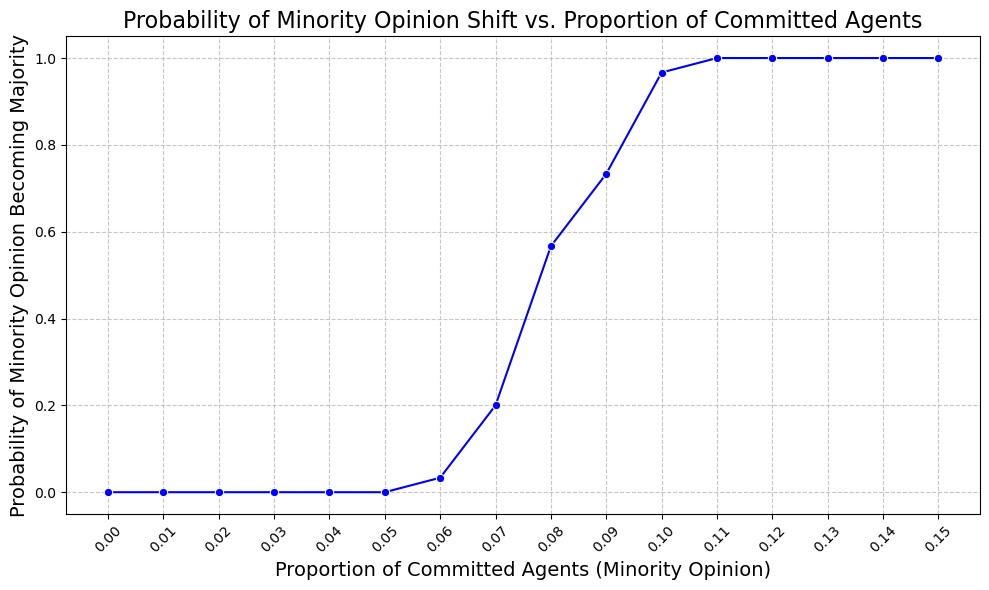

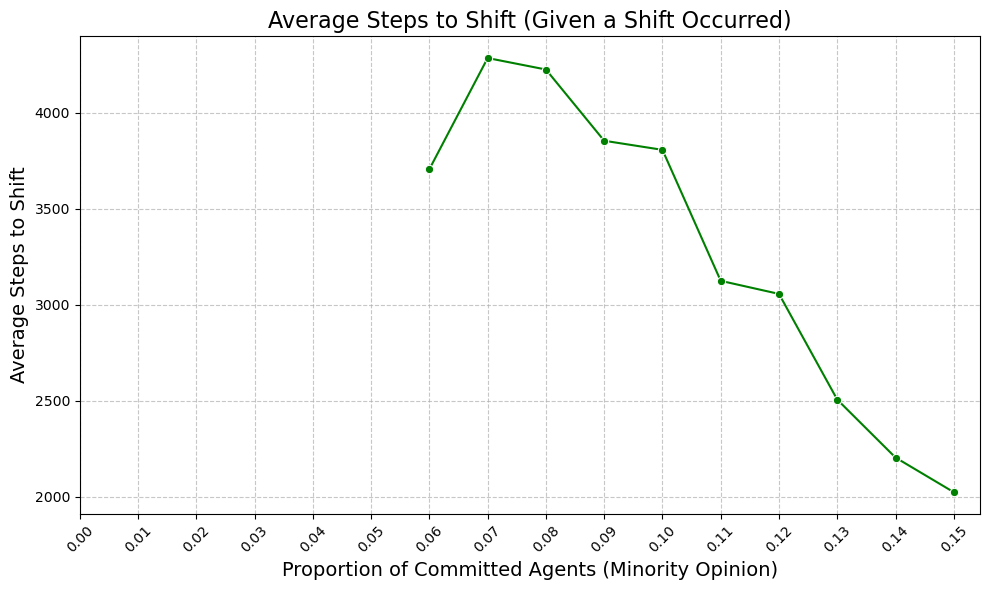

In [16]:
#Visualization

# Plotting Probability of Shift vs. Committed Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary_results, x='committed_ratio', y='probability_of_shift', marker='o', color='blue')

plt.title('Probability of Minority Opinion Shift vs. Proportion of Committed Agents', fontsize=16)
plt.xlabel('Proportion of Committed Agents (Minority Opinion)', fontsize=14)
plt.ylabel('Probability of Minority Opinion Becoming Majority', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(test_committed_ratios, rotation=45) # Show all tested ratios on x-axis
plt.ylim(-0.05, 1.05) # Ensure y-axis covers full probability range
plt.tight_layout()
plt.show()

#Plotting Average Steps to Shift
if not avg_steps_to_shift.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=avg_steps_to_shift, x='committed_ratio', y='average_steps_to_shift', marker='o', color='green')
    plt.title('Average Steps to Shift (Given a Shift Occurred)', fontsize=16)
    plt.xlabel('Proportion of Committed Agents (Minority Opinion)', fontsize=14)
    plt.ylabel('Average Steps to Shift', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(test_committed_ratios, rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No shifts occurred in any replication, so 'Average Steps to Shift' plot cannot be generated.")

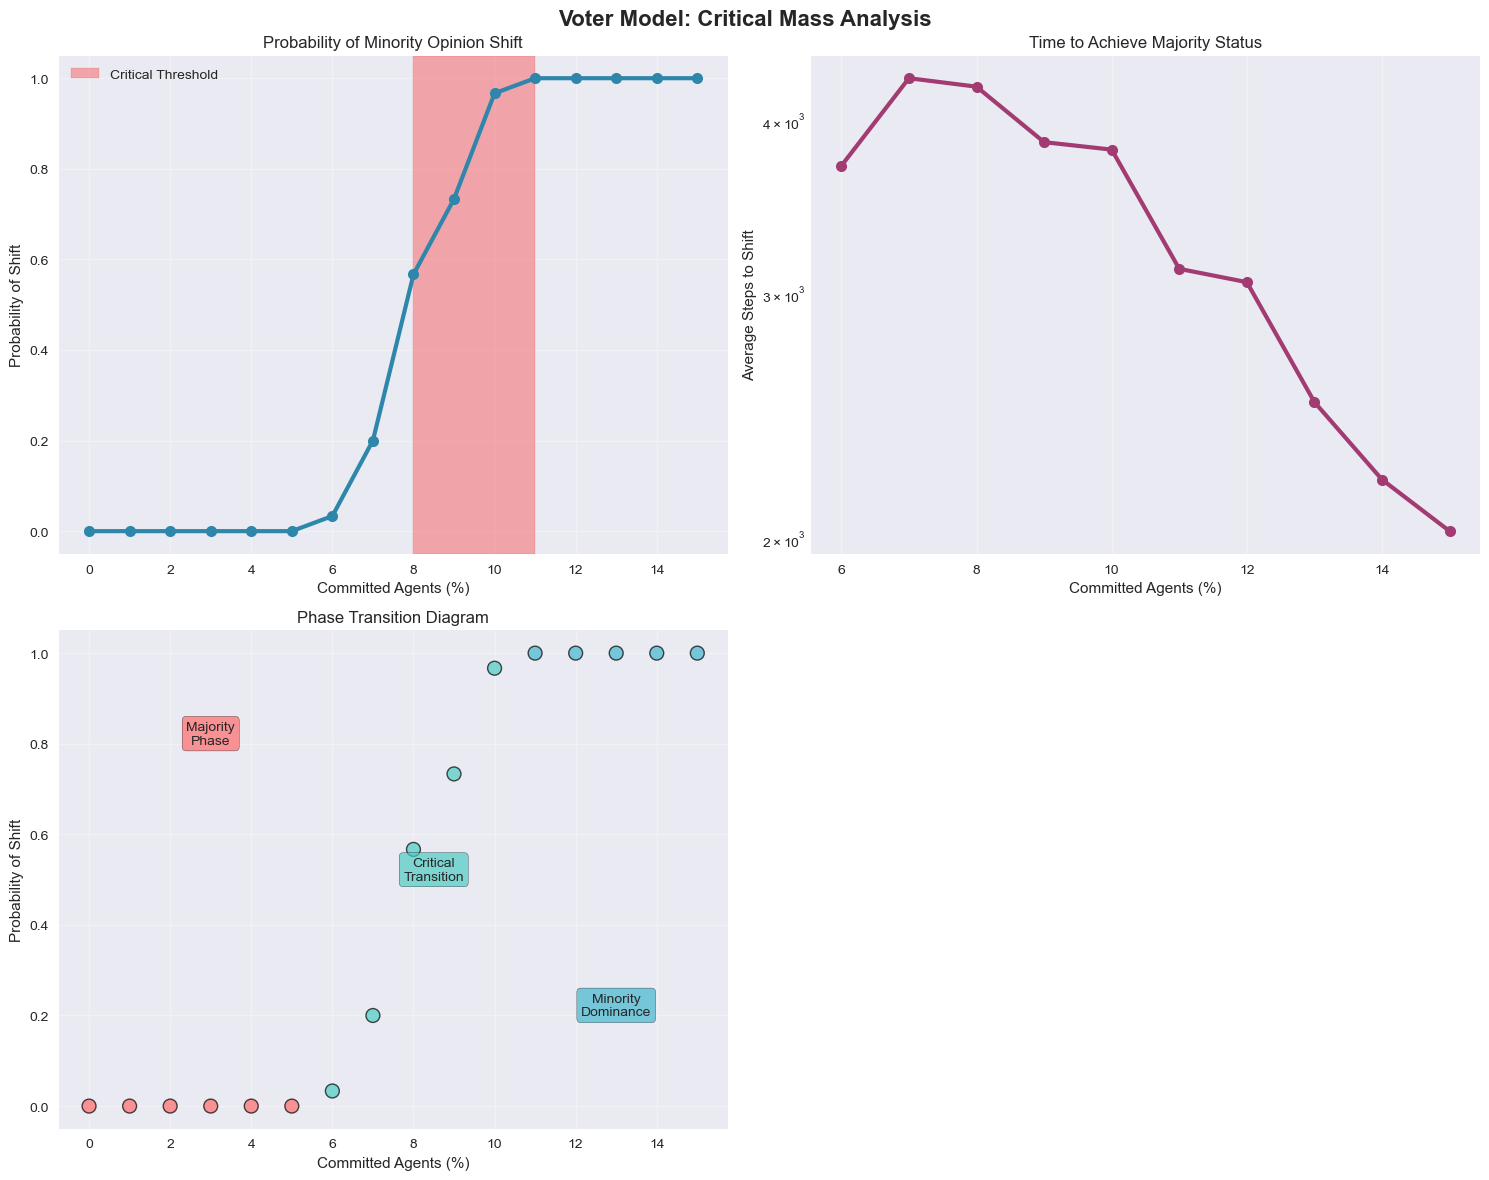

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Threshold data
data = {
    'committed_ratio': [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15],
    'probability_of_shift': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.033333, 0.2, 0.566667, 0.733333, 0.966667, 1.0, 1.0, 1.0, 1.0, 1.0],
    'average_steps_to_shift': [None, None, None, None, None, None, 3707, 4286.5, 4226.7, 3855.3, 3807.8, 3124.9, 3056.7, 2505.6, 2203.5, 2022.9]
}
df = pd.DataFrame(data)
df['committed_percentage'] = df['committed_ratio'] * 100

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Voter Model: Critical Mass Analysis', fontsize=16, fontweight='bold')

# 1. Probability of Shift
ax1 = axes[0, 0]
ax1.plot(df['committed_percentage'], df['probability_of_shift'], 'o-', lw=3, ms=8, color='#2E86AB')
ax1.axvspan(8, 11, alpha=0.3, color='red', label='Critical Threshold')
ax1.set(title='Probability of Minority Opinion Shift', xlabel='Committed Agents (%)', ylabel='Probability of Shift')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(-0.05, 1.05)

# 2. Average Steps to Shift
ax2 = axes[0, 1]
valid_steps = df.dropna(subset=['average_steps_to_shift'])
ax2.plot(valid_steps['committed_percentage'], valid_steps['average_steps_to_shift'], 'o-', lw=3, ms=8, color='#A23B72')
ax2.set(title='Time to Achieve Majority Status', xlabel='Committed Agents (%)', ylabel='Average Steps to Shift')
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# 3. Phase Transition Diagram
ax3 = axes[1, 0]
colors = ['#FF6B6B' if x < 6 else '#4ECDC4' if x < 11 else '#45B7D1' for x in df['committed_percentage']]
ax3.scatter(df['committed_percentage'], df['probability_of_shift'], c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax3.set(title='Phase Transition Diagram', xlabel='Committed Agents (%)', ylabel='Probability of Shift')
ax3.grid(True, alpha=0.3)

# Phase labels
ax3.text(3, 0.8, 'Majority\nPhase', fontsize=10, ha='center', bbox=dict(boxstyle="round", facecolor='#FF6B6B', alpha=0.7))
ax3.text(8.5, 0.5, 'Critical\nTransition', fontsize=10, ha='center', bbox=dict(boxstyle="round", facecolor='#4ECDC4', alpha=0.7))
ax3.text(13, 0.2, 'Minority\nDominance', fontsize=10, ha='center', bbox=dict(boxstyle="round", facecolor='#45B7D1', alpha=0.7))

# Remove unused subplot
fig.delaxes(axes[1][1])

plt.tight_layout()
plt.show()
